# Figure 1

In [8]:
import os
import numpy as np
import joblib
import h5py
import csv
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import StandardScaler

from stylia import ContinuousColorMap, NamedColors
from fragmentembedding import FragmentEmbedder
PAPER_WIDTH = 7.08661

## The chemistry-centric part

In [17]:
df = pd.read_csv("../data/finalScreen.tsv", sep="\t")
fids = sorted(set(df["fragId"]))
df = pd.read_csv("../data/fid2can_fff_all.tsv", sep="\t")
fid2smi = {}
for r in df.values:
    fid2smi[r[0]] = r[1]
df = pd.read_csv("../data/enamine_stock.csv")
screened_smiles = [fid2smi[fid] for fid in fids]
other_smiles = df["smiles"].tolist()
fid2naked = {}
with open("../data/fid2naked.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        fid2naked[r[0]] = r[1]

In [86]:
all_smiles = screened_smiles + other_smiles
fe = FragmentEmbedder()
X = fe.transform(all_smiles)

/Users/mduranfrigola/miniconda3/envs/bdfigs/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 967/967 [00:12<00:00, 74.77it/s]


In [10]:
xt_path = "../data/Xt_figure1.joblib"
if not os.path.exists(xt_path):
    reducer = UMAP(densmap=True, n_neighbors=30, low_memory=False, repulsion_strength=5, negative_sample_rate=50, verbose=True)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Xt = reducer.fit_transform(X)
    joblib.dump(Xt, xt_path)
else:
    Xt = joblib.load(xt_path)

In [18]:
# see archived repository bind-degs-paper-figures for rational behind selection of these compounds

import random
from rdkit.Chem import Descriptors
from rdkit import Chem

selected = ['C220', 'C351', 'C064', 'C003', 'C240', 'C328', 'C018', 'C391']

selected = ['C180', 'C337', 'C162', 'C323', 'C351', 'C328', 'C064', 'C220']

#selected = random.sample(fids, 20)

R = []
for i, fid in enumerate(fids):
    if fid in selected:
        sel = 1
    else:
        sel = 0
    mw = Descriptors.ExactMolWt(Chem.MolFromSmiles(fid2naked[fid]))
    R += [[fid, Xt[i, 0], Xt[i, 1], 1, sel, mw]]

for i in range(len(other_smiles)):
    R += [["O{0}".format(i), Xt[i+len(fids), 0], Xt[i+len(fids), 1], 0, 0, None]]

df = pd.DataFrame(R, columns=["FragID", "X", "Y", "CeMM", "Highlight", "MW"])

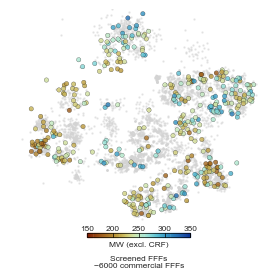

In [25]:
from matplotlib.patches import Rectangle
from scipy import interpolate

fig, ax = plt.subplots(1,1,figsize=(PAPER_WIDTH/2.6, PAPER_WIDTH/2.6))

cmap = ContinuousColorMap(cmap="spectral")
cmap.fit([150, 350])
ax.scatter(df["X"], df["Y"], s=0.5, color=NamedColors().gray, alpha=0.5)
colors = cmap.transform(df[df["CeMM"] == 1]["MW"])
x = df[df["CeMM"] == 1]["X"].tolist()
y = df[df["CeMM"] == 1]["Y"].tolist()
labels = df[df["CeMM"] == 1]["FragID"]
ax.scatter(x, y,
    s = 10,
    color = colors,
    edgecolor = NamedColors().black,
    alpha=0.8,
    lw = 0.2)

annotate = False
if annotate:

    x = df[df["Highlight"] == 1]["X"].tolist()
    y = df[df["Highlight"] == 1]["Y"].tolist()
    labels = df[df["Highlight"] == 1]["FragID"]
    ax.scatter(x, y, color="black", s=10)
    for x_, y_, z_ in zip(x, y, labels):
        ax.text(x_, y_, z_)

#ax.set_xlim(-50, 60)
ax.set_ylim(-50,55)
ax.grid()

xlim = ax.get_xlim()
ylim = ax.get_ylim()

rng = xlim[1] - xlim[0]
leg_start = xlim[0] + rng*0.3
leg_end = xlim[1] - rng*0.3

leg_rng = leg_end - leg_start
mw_ranges = np.linspace(150, 350, 100)
colors = cmap.transform(mw_ranges)
rect_starts = np.linspace(leg_start, leg_end, 100)
for i, x in enumerate(rect_starts[:-1]):
    r = Rectangle((x, ylim[0]), leg_rng/(len(rect_starts)-1), 2, color=colors[i], alpha=0.8)
    ax.add_patch(r)

func = interpolate.interp1d(mw_ranges, rect_starts)
vals = [150, 200, 250, 300, 350]
ticks = func(vals)

for i, t in enumerate(ticks):
    ax.plot([t, t], [ylim[0], ylim[0]+2], color="black", lw=0.5)
    ax.text(t, ylim[0]+4, s=vals[i], fontsize=6, va="center", ha="center")
ax.plot(func([150, 350]), [ylim[0], ylim[0]], color="black", lw=0.5)
ax.plot(func([150, 150]), [ylim[0]+2, ylim[0]+2], color="black", lw=0.5)
ax.plot(func([150, 350]), [ylim[0]+2, ylim[0]+2], color="black", lw=0.5)
ax.plot(func([350, 350]), [ylim[0], ylim[0]+2], color="black", lw=0.5)

ax.text(0.5*(leg_end-leg_start)+leg_start, ylim[0]-4, "MW (excl. CRF)", va="center", ha="center", fontsize=6)

ax.text(xlim[0]+0.5*(xlim[1] - xlim[0]), ylim[0]-12.5, "Screened FFFs\n~6000 commercial FFFs", fontsize=6, va="center", ha="center")

ax.set_ylim(-59, 65)

ax.set_axis_off()

plt.tight_layout()

if not annotate:
    plt.savefig("../assets/Figure01_B.png", dpi=300)
    plt.savefig("../assets/Figure01_B.pdf", dpi=300)
else:
    plt.savefig("../assets/Figure01_B_annotated.png", dpi=300)

df.to_csv("../data/compound_chemical_space.tsv", sep="\t", index=False)

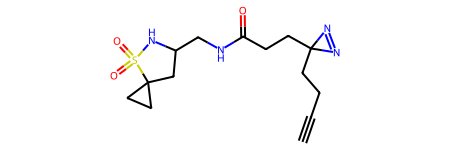

In [332]:
Chem.MolFromSmiles(fid2smi["C180"])

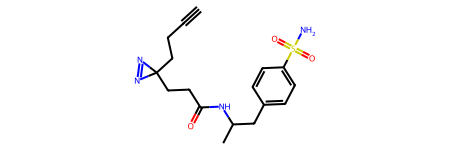

In [333]:
Chem.MolFromSmiles(fid2smi["C351"])

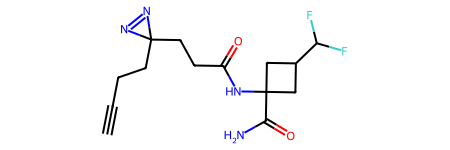

In [334]:
Chem.MolFromSmiles(fid2smi["C323"])

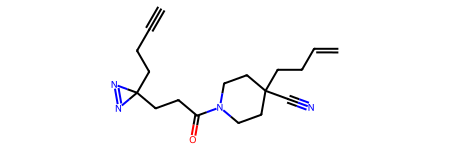

In [335]:
Chem.MolFromSmiles(fid2smi["C337"])

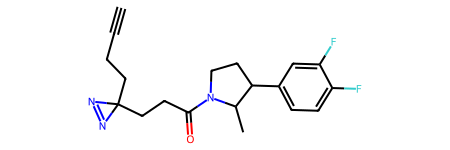

In [336]:
Chem.MolFromSmiles(fid2smi["C220"])

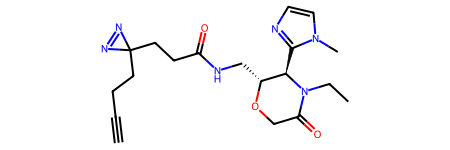

In [337]:
Chem.MolFromSmiles(fid2smi["C162"])

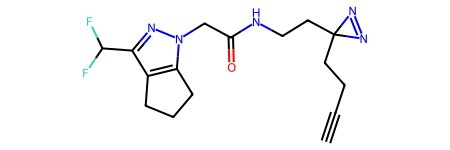

In [338]:
Chem.MolFromSmiles(fid2smi["C064"])

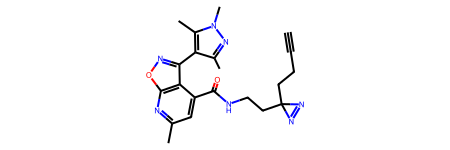

In [339]:
Chem.MolFromSmiles(fid2smi["C328"])

In [28]:
import sys
sys.path.append("../")

from utils.descriptor import classic_featurizer

dp = classic_featurizer([fid2naked[fid] for fid in fids])

In [34]:
data_for_table = pd.DataFrame({"fragId": [fid for fid in fids], "SMILES": [fid2smi[fid] for fid in fids], "SMILES Naked": [fid2naked[fid] for fid in fids]})
data_for_table = pd.concat([data_for_table, dp], axis=1)
data_for_table.to_csv("../assets/assayed_fragments_with_properties.csv", index=False)


In [35]:
df = pd.read_csv("../data/compound_chemical_space.tsv", sep="\t")
df = pd.concat([df, dp], axis = 1)
df.to_csv("../data/compound_chemical_space_properties.tsv", sep="\t", index=False)

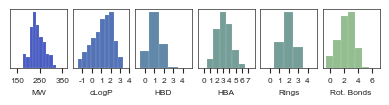

In [53]:
fig, axs = plt.subplots(1, 6, figsize=(PAPER_WIDTH*0.53, 0.9))
axs = axs.flatten()

cmap = ContinuousColorMap(cmap="viridis")
cmap.fit([0, 1, 2, 3, 4, 5, 6])
colors = cmap.transform([0, 1, 2, 3, 4, 5])

ax = axs[0]
ax.hist(df["MW"], bins=10, lw=0.1, color=colors[0], alpha=0.8)
ax.set_xlabel("MW", fontsize=6)
ax.yaxis.set_visible(False)
ax.set_xlim(120, 370)
ticks = [150, 250, 350]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, fontsize=6)
ax.grid()

ax = axs[1]
ax.hist(df["cLogP"], bins=10, lw=0.1, color=colors[1], alpha=0.8)
ax.yaxis.set_visible(False)
ax.set_xlim(-2, 4)
ticks = [-1, 0, 1, 2, 3, 4]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, fontsize=6)
ax.set_xlabel("cLogP", fontsize=6)
ax.grid()

ax = axs[2]
ax.yaxis.set_visible(False)
ticks = [0, 1, 2, 3, 4]
ax.hist(df["HBD"], bins=[x-0.5 for x in ticks], lw=0.1, color=colors[2], alpha=0.8)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, fontsize=6)
ax.set_xlim(-1, 5)
ax.set_xlabel("HBD", fontsize=6)
ax.grid()

ax = axs[3]
ax.yaxis.set_visible(False)
ticks = [0, 1, 2, 3, 4, 5, 6, 7]
ax.hist(df["HBA"], bins=[x-0.5 for x in ticks], lw=0.1, color=colors[3], alpha=0.8)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, fontsize=6)
ax.set_xlim(-1, 8)
ax.set_xlabel("HBA", fontsize=6)
ax.grid()

ax = axs[4]
ax.yaxis.set_visible(False)
ticks = [0, 1, 2, 3, 4]
ax.hist(df["Rings"], bins=[x-0.5 for x in ticks], lw=0.1, color=colors[3], alpha=0.8)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, fontsize=6)
ax.set_xlim(-1, 5)
ax.set_xlabel("Rings", fontsize=6)
ax.grid()

ax = axs[5]
ax.yaxis.set_visible(False)
ticks = [0, 2, 4, 6]
ax.hist(df["Rot. Bonds"], bins=[x-0.5 for x in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]], lw=0.1, color=colors[4], alpha=0.8, zorder=1000)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, fontsize=6)
ax.set_xlim(-1, 7)
ax.set_xlabel("Rot. Bonds", fontsize=6)
ax.grid()

plt.tight_layout(pad=0.3)
plt.savefig("../assets/Figure01_C.png", dpi=300, bbox_inches='tight')
plt.savefig("../assets/Figure01_C.pdf", dpi=300, bbox_inches='tight')

## The protein-centric part

In [63]:
df = pd.read_csv("../data/finalScreen.tsv", sep="\t")
df = df[df["nUniq"] >= 2]
db = df[df["l2fc"] >= 2.3]
db = db[db["l2fcM"] >= 1]
db = db[db["ml10p"] > -np.log10(0.05)]
db = db[db["ml10adjP"] > -np.log10(2.5)]
db = db[db["rankRel"] < 500]

fingerprinted_fragments = sorted(set([x.split("-")[0] for x in list(set(pd.read_csv("../data/finalFp.tsv", sep="\t")["fragId"]))]).intersection(df["fragId"]))

In [64]:
import collections

pid2name = {}
with open("../data/pid2name_primary.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        pid2name[r[0]] = r[1]

hp = pd.read_csv("../data/human_proteome_with_gene_names.tab", sep="\t")
hp = hp[~hp['Gene names  (primary )'].isnull()]
for r in hp[["Entry", 'Gene names  (primary )']].values:
    if r[0] not in pid2name:
        pid2name[r[0]] = r[1]

def read_annotations(file_name):
    fn = os.path.join("../data/{0}.tsv".format(file_name))
    R = []
    with open(fn, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for r in reader:
            R += [[r[0], r[1]]]
    return R

protein_counts = collections.defaultdict(int)
for r in list(db["accession"]):
    protein_counts[r] += 1

In [65]:
with h5py.File("../data/Xp_panther.h5", "r") as f:
    pids = [x.decode() for x in f["Keys"][:]]
    Xp = f["Values"][:]

pid2idx = dict((k, i) for i,k in enumerate(pids))

human_proteome = []
with open("../data/human_proteome.tsv", "r") as f:
    reader = csv.reader(f)
    for r in reader:
        human_proteome += [r[0]]
human_proteome = set(human_proteome)

hek_proteome = []
with open("../data/hek293t_core.tsv", "r") as f:
    reader = csv.reader(f)
    for r in reader:
        hek_proteome += [r[0]]
hek_proteome = set(hek_proteome)

enriched_proteome = []
enriched_proteome = set(db["accession"])

detected_proteome = []
detected_proteome = set(df["accession"])

tclin_proteome = []
with open("../data/pharos_protein_category.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        if r[1] == "Tclin":
            tclin_proteome += [r[0]]
tclin_proteome = set(tclin_proteome)

tchem_proteome = []
with open("../data/pharos_protein_category.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        if r[1] == "Tchem":
            tchem_proteome += [r[0]]
tchem_proteome = set(tchem_proteome)

tclinchem_proteome = []
with open("../data/pharos_protein_category.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        if r[1] == "Tclin" or r[1] == "Tchem":
            tclinchem_proteome += [r[0]]
tclinchem_proteome = set(tclinchem_proteome)

In [66]:
anns = read_annotations("pharos_dto")
pid2ann = collections.defaultdict(list)
for r in anns:
    pid2ann[r[0]] += [r[1]]

ann2pid = collections.defaultdict(list)
for pid in list(human_proteome):
    if pid not in pid2ann:
        ann2pid["Unknown"] += [pid]
    else:
        for x in pid2ann[pid]:
            ann2pid[x] += [pid]

ann2pid = dict((k, set(v)) for k,v in ann2pid.items())

ann2pid_sorted = sorted(ann2pid.items(), key = lambda x: -len(x[1]))

keeps = sorted([x[0] for x in ann2pid_sorted[:50]], key = lambda x: x.lower())

In [67]:
df = pd.read_csv("../data/finalScreen.tsv", sep="\t")

file_path = "../data/proteome_clusters.joblib"
if os.path.exists(file_path):
    cluster_labels = joblib.load(file_path)
else:
    import hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
    cluster_labels = clusterer.fit_predict(Xp)
    joblib.dump(cluster_labels, file_path)

In [68]:
def find_cluster_term(cluster_id, fold=3):
    pids_ = set(list(np.array(pids)[cluster_labels == cluster_id]))
    for k,v in ann2pid.items():
        if len(v) < 40:
            continue
        if len(pids_.intersection(v)) > len(v)/fold:
            print(cluster_id, k, len(v))
            return k
    return None

def find_some_cluster_term(cluster_id, fold=2, min_size=20):
    pids_ = set(list(np.array(pids)[cluster_labels == cluster_id]))
    for k,v in ann2pid.items():
        if len(v) < min_size:
            continue
        intersect = len(pids_.intersection(v))
        if intersect > len(v)/fold:
            print(cluster_id, k, len(v), len(pids_), intersect)
    return None

def hitted_degree(cluster_id, term):
    pids_ = set(list(np.array(pids)[cluster_labels == cluster_id]))
    pids_ = pids_.intersection(ann2pid[term])
    intersect = len(pids_.intersection(enriched_proteome))
    if intersect > 5:
        print(term,  cluster_id, "covered", intersect)
    elif intersect > 0:
        print(term, cluster_id, "hitted", intersect)
    else:
        print(term, cluster_id, "orphan", intersect)

all_clusters = sorted(set(cluster_labels[cluster_labels != -1]))

pairs = []
for clust in all_clusters:
    term = find_cluster_term(clust)
    if term is not None:
        pairs += [(term, clust)]

5 Serine protease inhibitor 67
14 Immunoglobulin receptor superfamily 72
21 Neurotransmitter receptor, Cys loop, ligand-gated ion channel (LIC) family 45
70 Nuclear receptor 48
72 Small GTPase 80
76 Kinase activator 46
82 Immune response 121
88 SLC25 family of mitochondrial transporters 52
91 Phospholipase 43
115 Oxygenase 67
154 KRAB box transcription factor 183
158 Basic helix-loop-helix transcription factor 59
164 Homeodomain transcription factor 94
170 Chemokine 48
172 AGC group 62
179 Cytokine 49
193 Cell adhesion 67
232 Guanyl-nucleotide exchange factor 57
241 CAMK group 76
243 Hormone 47
245 Ribosomal protein 151
246 TK group 91
252 Potassium channel family 52
253 CMGC group 66
293 Cell-cell junction 61
314 Microtubule binding motor protein 47
352 Lyase 49
367 Methyltransferase 44


In [362]:
for p in pairs:
    hitted_degree(p[1], p[0])

Serine protease inhibitor 5 orphan 0
Immunoglobulin receptor superfamily 14 orphan 0
Neurotransmitter receptor, Cys loop, ligand-gated ion channel (LIC) family 21 orphan 0
Nuclear receptor 70 hitted 1
Small GTPase 72 hitted 5
Kinase activator 76 orphan 0
Immunoglobulin 82 orphan 0
SLC25 family of mitochondrial transporters 88 covered 27
Phospholipase 91 hitted 1
Oxygenase 115 hitted 1
KRAB box transcription factor 154 orphan 0
Basic helix-loop-helix transcription factor 158 orphan 0
Winged helix/forkhead transcription factor 164 orphan 0
Chemokine 170 orphan 0
AGC group 172 covered 6
Cytokine 179 orphan 0
Cell adhesion 193 hitted 1
Guanyl-nucleotide exchange factor 232 hitted 2
CAMK group 241 hitted 2
Hormone 243 orphan 0
Ribosomal protein 245 covered 10
TK group 246 hitted 4
Potassium channel family 252 orphan 0
CMGC group 253 covered 11
Cell-cell junction 293 hitted 1
Microtubule binding motor protein 314 hitted 4
Lyase 352 hitted 5
Methyltransferase 367 hitted 4


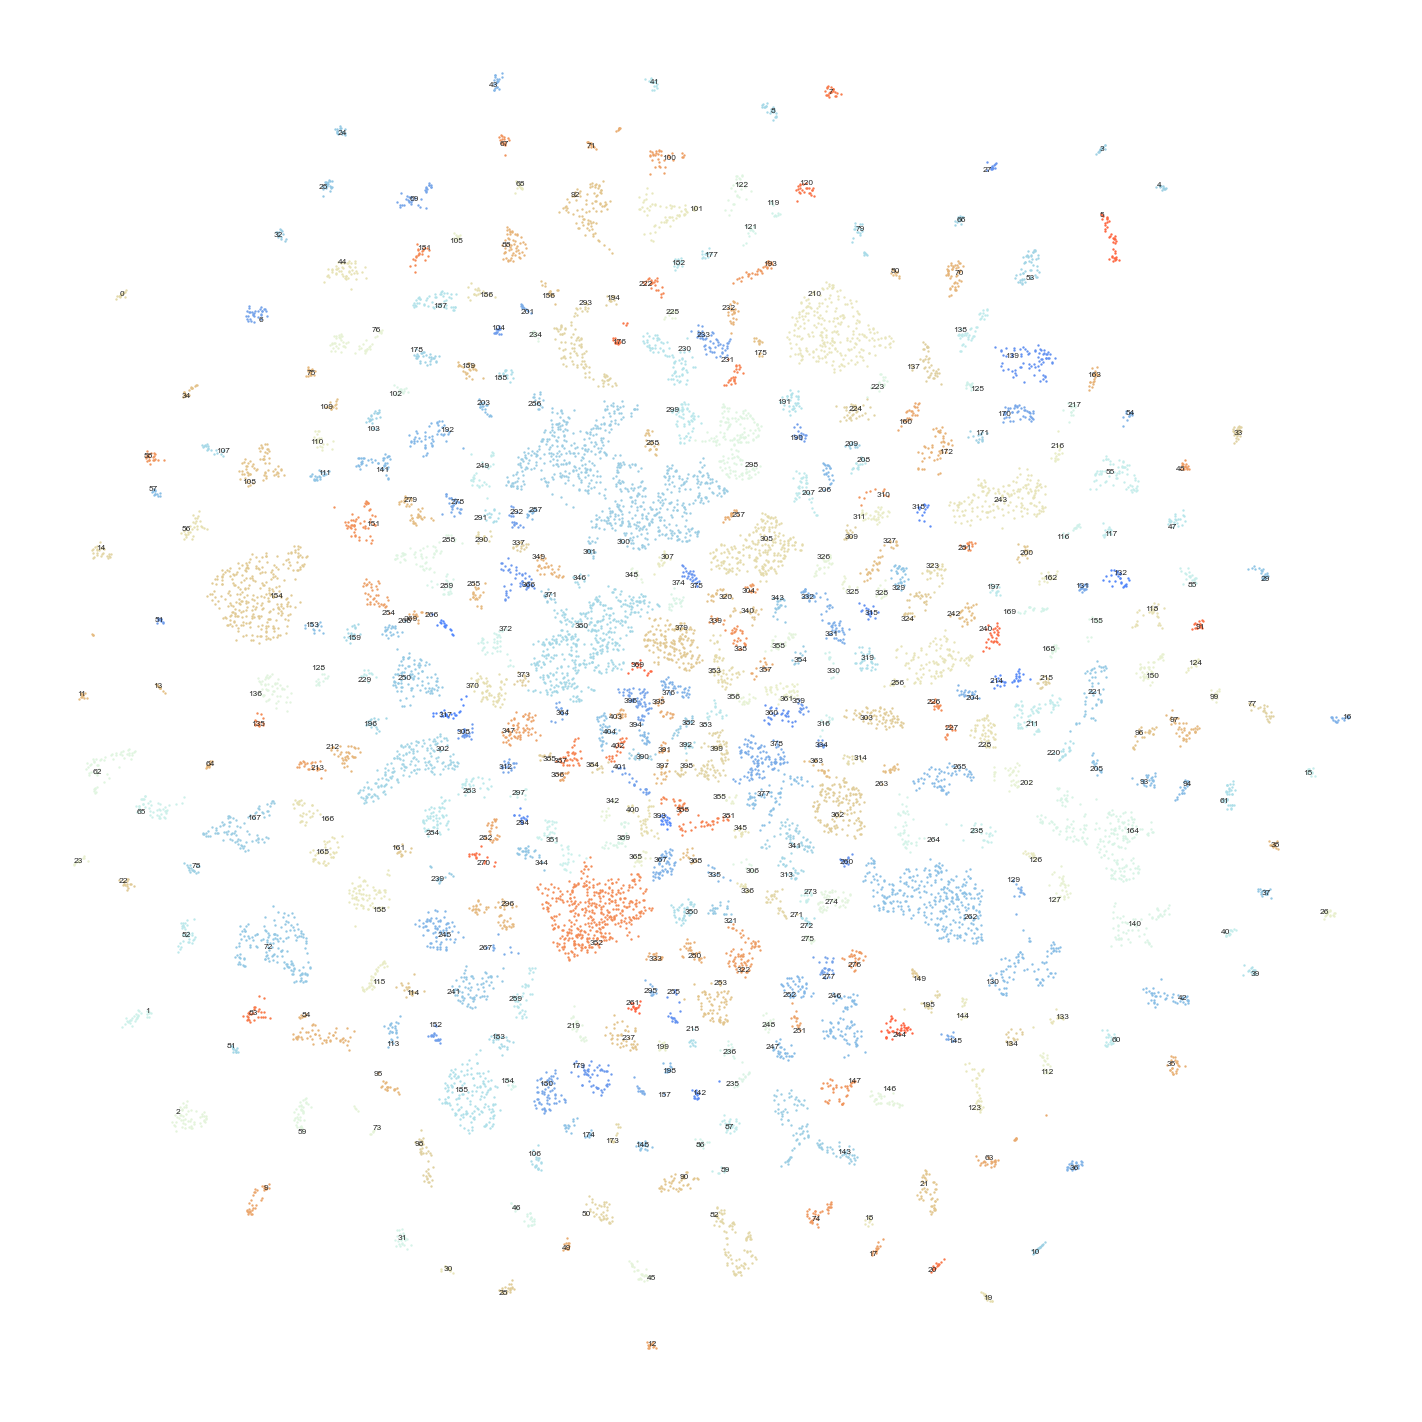

In [69]:
import random
from matplotlib.collections import PolyCollection

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

mask = cluster_labels != -1

cluster_orig = list(set(cluster_labels[mask]))
cluster_remap = [x for x in cluster_orig]
random.seed(42)
random.shuffle(cluster_remap)
remap = {}
remap[-1] = -1
for x,y in zip(cluster_orig, cluster_remap):
    remap[x] = y

cmap = ContinuousColorMap(cmap="spectral")
cmap.fit(sorted(set(cluster_labels[cluster_labels != -1])))

def add_cluster(ax, cluster_id):
    mask = cluster_labels == cluster_id
    x = Xp[mask, 0]
    y = Xp[mask, 1]
    color = lighten_color(cmap.transform([remap[cluster_id]])[0], amount=0.5)
    ax.scatter(x, y, color=color, s=0.5)
    ax.text(x[0], y[0], cluster_id, va="center", ha="center", fontsize=6)

fig, axs = plt.subplots(1,1, figsize=(PAPER_WIDTH*2, PAPER_WIDTH*2))
ax = axs
ax.set_xlim(-31.813871383666992, 44.33376121520996)
ax.set_ylim(-38.62340068817139, 38.55760097503662)
ax.set_axis_off()

for cluster in list(set(cluster_labels[cluster_labels != -1])):
    add_cluster(ax, cluster)

R = []
for p in enriched_proteome:
    R += [[Xp[pid2idx[p],0], Xp[pid2idx[p], 1]]]
R = np.array(R)
#ax.scatter(R[:,0], R[:,1], s=2, lw=0, color="black", edgecolor="none")

plt.tight_layout()
plt.savefig("../assets/Figure01_D_annotated.png", dpi=600)

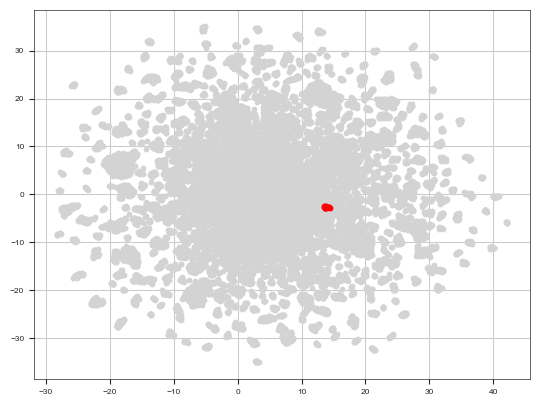

In [70]:
def locate_cluster(cluster_id):
    mask = cluster_labels == cluster_id
    plt.scatter(Xp[:,0], Xp[:,1], color="lightgray")
    plt.scatter(Xp[mask,0], Xp[mask,1], color="red")

locate_cluster(314)

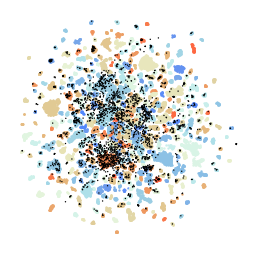

In [365]:
import random
from matplotlib.collections import PolyCollection

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

mask = cluster_labels != -1

cluster_orig = sorted(set(cluster_labels[mask]))
cluster_remap = [x for x in cluster_orig]
random.seed(42)
random.shuffle(cluster_remap)
remap = {}
remap[-1] = -1
for x,y in zip(cluster_orig, cluster_remap):
    remap[x] = y

cmap = ContinuousColorMap(cmap="spectral")
cmap.fit(sorted(set(cluster_labels[cluster_labels != -1])))

def add_cluster(ax, cluster_id):
    mask = cluster_labels == cluster_id
    x = Xp[mask, 0]
    y = Xp[mask, 1]
    color = lighten_color(cmap.transform([remap[cluster_id]])[0], amount=0.5)
    ax.scatter(x, y, color=color, s=0.5)

fig, axs = plt.subplots(1,1, figsize=(PAPER_WIDTH/2*0.7, PAPER_WIDTH/2*0.7))
ax = axs
ax.set_xlim(-31.813871383666992, 44.33376121520996)
ax.set_ylim(-38.62340068817139, 38.55760097503662)
ax.set_axis_off()

for cluster in list(set(cluster_labels[cluster_labels != -1])):
    add_cluster(ax, cluster)

R = []
for p in enriched_proteome:
    R += [[Xp[pid2idx[p],0], Xp[pid2idx[p], 1]]]
R = np.array(R)
ax.scatter(R[:,0], R[:,1], s=1, lw=0, color="black", edgecolor="none")

plt.tight_layout()
plt.savefig("../assets/Figure01_D.png", dpi=600)
plt.savefig("../assets/Figure01_D.pdf")

SLC25A33 110
SLC25A42 19
SLC25A44 42
SLC25A21 59
SLC25A24 34
SLC25A16 6
SLC25A32 179
SLC25A1 3
SLC25A12 5
SLC25A20 143
MTCH1 70
SLC25A4 39
SLC25A3 4
SLC25A19 41
SLC25A22 4
SLC25A13 16
SLC25A6 39
SLC25A26 199
SLC25A11 9
SLC25A40 6
SLC25A35 5
SLC25A25 22
SLC25A17 27
SLC25A5 17
MTCH2 73
SLC25A10 140
SLC25A15 101


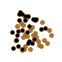

In [366]:
df = db
protein_counts = collections.defaultdict(int)
for r in list(df["accession"]):
    protein_counts[r] += 1

def focus_on_cluster_plot(ax, cluster_id, term):
    color = cmap.transform([remap[cluster_id]])[0]
    mask = cluster_labels == cluster_id
    x = Xp[mask,0]
    y = Xp[mask,1]
    pids_ = np.array(pids)[mask]
    ax.scatter(x, y, s=5, color=NamedColors().gray, clip_on=False)
    for i, p in enumerate(pids_):
        if p in ann2pid[term]:
            ax.scatter([x[i]], [y[i]], color=color, s=6, alpha=0.8, clip_on=False)
            if p in enriched_proteome:
                ax.scatter([x[i]], [y[i]], color="black", s=3, zorder=1000, clip_on=False)
                print(pid2name[p], protein_counts[p])

fig, ax = plt.subplots(1,1,figsize=(0.55,0.55))
focus_on_cluster_plot(ax, 88, "SLC25 family of mitochondrial transporters")
ax.set_axis_off()
plt.savefig("../assets/Figure01_D_1.png", dpi=600)
plt.savefig("../assets/Figure01_D_1.pdf", dpi=600)

CDK4 1
CLK3 1
GSK3B 1
CDK9 5
CDK5 1
CDK1 3
SRPK1 1
MAPK14 3
CDK16 2
CDK2 3
GSK3A 7


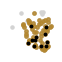

In [367]:
fig, ax = plt.subplots(1,1,figsize=(0.55,0.55))
focus_on_cluster_plot(ax, 253, "CMGC group")
ax.set_axis_off()
plt.savefig("../assets/Figure01_D_2.png", dpi=600)
plt.savefig("../assets/Figure01_D_2.pdf", dpi=600)

PRKACB 1
PRKCB 2
AKT2 28
RPS6KA1 27
PRKCD 1
AKT1 7


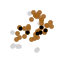

In [368]:
fig, ax = plt.subplots(1,1,figsize=(0.55,0.55))
focus_on_cluster_plot(ax, 172, "AGC group")
ax.set_axis_off()
plt.savefig("../assets/Figure01_D_3.png", dpi=600)
plt.savefig("../assets/Figure01_D_3.pdf", dpi=600)

RPL36A 1
RPL19 1
RPS15 1
RPS3 5
RPL29 3
RPL26 7
RPL35A 4
RPS24 4
RPS13 2
RPS23 2


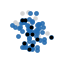

In [369]:
fig, ax = plt.subplots(1,1,figsize=(0.55,0.55))
focus_on_cluster_plot(ax, 245, "Ribosomal protein")
ax.set_axis_off()
plt.savefig("../assets/Figure01_D_4.png", dpi=600)
plt.savefig("../assets/Figure01_D_4.pdf", dpi=600)

In [370]:
find_some_cluster_term(211, 100, 10)

211 Enzyme 2388 69 30
211 Transferase 467 69 17
211 Reductase 40 69 3
211 Oxidoreductase 364 69 12
211 Acyltransferase 54 69 12
211 Dehydrogenase 140 69 4
211 Acetyltransferase 53 69 5
211 Oxidase 65 69 4


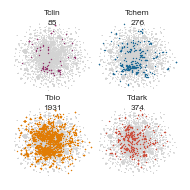

In [258]:
import numpy as np
fig, axs = plt.subplots(2,2,figsize=(1.7,1.7))

def read_proteome(term):
    proteome = []
    with open("../data/pharos_protein_category.tsv", "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for r in reader:
            if r[0] not in enriched_proteome:
                continue
            if r[1] == term:
                proteome += [r[0]]
    proteome = set(proteome)
    return proteome

def get_xy(proteome):
    x = []
    y = []
    for i, pid in enumerate(pids):
        if pid in proteome:
            x += [Xp[i, 0]]
            y += [Xp[i, 1]]
    return x, y

ax = axs[0,0]
ax.scatter(Xp[:,0], Xp[:,1], lw=0, s=0.1, color=NamedColors().gray, alpha=0.8)
proteome = read_proteome("Tclin")
x,y = get_xy(proteome)
ax.scatter(x, y, s=1, color=NamedColors().purple, lw=0)
ax.set_axis_off()
ax.set_title("Tclin", fontsize=6)
ax.set_ylim(np.min(Xp[:,1])-5, np.max(Xp[:,1]))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0] + 0.5*(xlim[1] - xlim[0]), ylim[1], len(proteome), fontsize=6, ha="center", va="center")


ax = axs[0,1]
ax.scatter(Xp[:,0], Xp[:,1], lw=0, s=0.1, color=NamedColors().gray, alpha=0.8)
proteome = read_proteome("Tchem")
x,y = get_xy(proteome)
ax.scatter(x, y, s=1, color=NamedColors().blue, lw=0)
ax.set_axis_off()
ax.set_title("Tchem", fontsize=6)
ax.set_ylim(np.min(Xp[:,1])-5, np.max(Xp[:,1]))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0] + 0.5*(xlim[1] - xlim[0]), ylim[1], len(proteome), fontsize=6, ha="center", va="center")


ax = axs[1,0]
ax.scatter(Xp[:,0], Xp[:,1], lw=0, s=0.1, color=NamedColors().gray, alpha=0.8)
proteome = read_proteome("Tbio")
x,y = get_xy(proteome)
ax.scatter(x, y, s=1, color=NamedColors().orange, lw=0)
ax.set_axis_off()
ax.set_title("Tbio", fontsize=6)
ax.set_ylim(np.min(Xp[:,1])-5, np.max(Xp[:,1]))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0] + 0.5*(xlim[1] - xlim[0]), ylim[1], len(proteome), fontsize=6, ha="center", va="center")


ax = axs[1,1]
ax.scatter(Xp[:,0], Xp[:,1], lw=0, s=0.1, color=NamedColors().gray, alpha=0.8)
proteome = read_proteome("Tdark")
x,y = get_xy(proteome)
ax.scatter(x, y, s=1, color=NamedColors().red, lw=0)
ax.set_axis_off()
ax.set_title("Tdark", fontsize=6)
ax.set_ylim(np.min(Xp[:,1])-5, np.max(Xp[:,1]))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0] + 0.5*(xlim[1] - xlim[0]), ylim[1], len(proteome), fontsize=6, ha="center", va="center")

plt.tight_layout(pad=0)
plt.savefig("../assets/Figure01_G.png", dpi=600, bbox_inches='tight')
plt.savefig("../assets/Figure01_G.pdf", bbox_inches='tight')

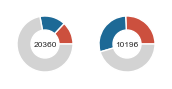

In [259]:
from matplotlib.patches import Circle

fig, axs = plt.subplots(1, 2, figsize=(1.7, 0.7))
axs = axs.flatten()

ax = axs[1]

e = len(enriched_proteome.intersection(hek_proteome))
d = len(detected_proteome.intersection(hek_proteome).difference(enriched_proteome))
t = len(hek_proteome) - (e+d)

ax.pie([e, d, t], colors=[NamedColors().red, NamedColors().blue, NamedColors().gray], counterclock=True)
c = Circle([0,0],0.5, color="white")
ax.add_patch(c)
ax.text(0,0, len(hek_proteome), ha="center", va="center", fontsize=6)

ax = axs[0]

e = len(enriched_proteome.intersection(human_proteome))
d = len(detected_proteome.intersection(human_proteome).difference(enriched_proteome))
t = len(human_proteome) - (e+d)

ax.pie([e, d, t], colors=[NamedColors().red, NamedColors().blue, NamedColors().gray], counterclock=True)
c = Circle([0,0],0.5, color="white")
ax.text(0,0, len(human_proteome), ha="center", va="center", fontsize=6)
ax.add_patch(c)

plt.tight_layout(pad=0)
plt.savefig("../assets/Figure01_E.png", dpi=600, bbox_inches='tight')
plt.savefig("../assets/Figure01_E.pdf", bbox_inches='tight')


interactions 1296781 47658
proteins 5683 2667
fragments 407 378


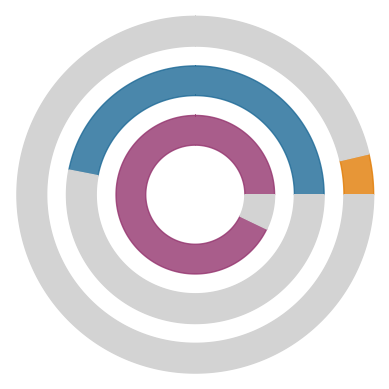

In [72]:
gray = NamedColors().gray

ax = plt.subplot(projection="polar")

df = pd.read_csv("../data/finalScreen.tsv", sep="\t")
df = df[df["nUniq"] >= 2]

ni = df.shape[0]
ne = db.shape[0]
print("interactions", ni, ne)
d = ne/ni
theta = np.linspace(0, d*2*np.pi, 1000)
ax.fill_between(theta, [1.5]*len(theta), [1.8]*len(theta), color=NamedColors().orange, alpha=0.8)
theta = np.linspace(d*2*np.pi, 2*np.pi, 1000)
ax.fill_between(theta, [1.5]*len(theta), [1.8]*len(theta), color=gray)

ni = len(set(df['accession']))
ne = len(set(db["accession"]))
print("proteins", ni, ne)
d = ne/ni
theta = np.linspace(0, d*2*np.pi, 1000)
ax.fill_between(theta, [1]*len(theta), [1.3]*len(theta), color=NamedColors().blue, alpha=0.8)
theta = np.linspace(d*2*np.pi, 2*np.pi, 1000)
ax.fill_between(theta, [1]*len(theta), [1.3]*len(theta), color=gray)

ni = len(set(df["fragId"]))
ne = len(set(db["fragId"]))
print("fragments", ni, ne)
d = ne/ni
theta = np.linspace(0, d*2*np.pi, 1000)
ax.fill_between(theta, [.5]*len(theta), [.8]*len(theta), color=NamedColors().purple, alpha=0.8)
theta = np.linspace(d*2*np.pi, 2*np.pi, 1000)
ax.fill_between(theta, [.5]*len(theta), [.8]*len(theta), color=gray)

ax.set_axis_off()

plt.savefig("../assets/Figure01_F.pdf")
plt.savefig("../assets/Figure01_F.png", dpi=600)

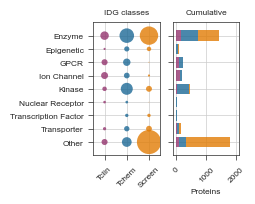

In [281]:
from matplotlib.patches import Rectangle

fig, axs = stylia.create_figure(1, 2, width = 2.5, height = 2, width_ratios=[1, 1])

ax = axs.next()

R = read_annotations("idg_family")

exclude = ["oGPCR", "TF-Epigenetic", "Other"]

terms = sorted(set([x[1] for x in R if x[1] not in exclude])) + ["Other"]
ann2pid = collections.defaultdict(list)
for r in R:
    ann2pid[r[1]] += [r[0]]

colors = [NamedColors().purple, NamedColors().blue, NamedColors().orange]

for i, t in enumerate(terms):
    y = len(terms) - (i+1)
    tpids = ann2pid[t]
    tclin_pids = set(tpids).intersection(tclin_proteome)
    tchem_pids = set(tpids).intersection(tchem_proteome)
    tenri_pids = set(tpids).intersection(enriched_proteome)
    x = [0,1,2]
    s = np.array([len(tclin_pids), len(tchem_pids), len(tenri_pids)])
    ax.scatter(x, [y]*3, color=[colors[j] for j in x], s=s*0.2, alpha=0.8, lw=0)

ax.set_xticks([0,1,2])
ax.set_xticklabels(["Tclin", "Tchem", "Screen"], rotation=45)
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([-1, len(terms)])
ax.set_yticks([i for i in range(len(terms))])
ax.set_yticklabels(terms[::-1])
stylia.label(ax, ylabel="", title="IDG classes", xlabel="")
ax.set_ylabel("")

ax = axs.next()

for i, t in enumerate(terms):
    y = len(terms) - (i+1)
    tpids = ann2pid[t]
    tclin_pids = set(tpids).intersection(tclin_proteome)
    tchem_pids = set(tpids).intersection(tchem_proteome)
    tenri_pids = set(tpids).intersection(enriched_proteome)
    current = tclin_pids
    x = [0, len(current)]
    current.update(tchem_pids)
    x += [len(current)]
    current.update(tenri_pids)
    x += [len(current)]
    for i in range(len(x)-1):
        r = Rectangle((x[i],y-0.4), x[i+1] - x[i], 0.8, facecolor=colors[i], alpha=0.8, lw=0, edgecolor="white")
        ax.add_patch(r)
    s = np.array([len(tclin_pids), len(tchem_pids), len(tenri_pids)])
    

ax.set_ylabel("")
ax.set_yticklabels([])
ax.set_ylim([-1, len(terms)])
ax.set_xlim(-100, 2100)
ax.set_xticks([0, 1000, 2000])
ax.set_xticklabels([0, 1000, 2000], rotation=45)
stylia.label(ax, ylabel="", title="Cumulative", xlabel="Proteins")

stylia.save_figure("../assets/Figure01_I.png")
stylia.save_figure("../assets/Figure01_I.pdf")

set()


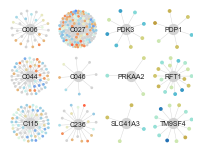

In [74]:
import networkx as nx
import stylia
import h5py

with h5py.File("../data/Xp_panther.h5", "r") as f:
    pids = [x.decode() for x in f["Keys"][:]]

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

cmap_mw = ContinuousColorMap(cmap="spectral")
cmap_mw.fit([150, 350])

name2pid = dict((v,k) for k,v in pid2name.items())

pid2idx = dict((k,i) for i,k in enumerate(pids))
def get_protein_color(pid):
    cluster_id = cluster_labels[pid2idx[pid]]
    if cluster_id == -1:
        return gray
    else:
        return lighten_color(cmap.transform([remap[cluster_id]])[0], amount=0.5)
    
def get_fragment_color(fid):
    smi = fid2naked[fid]
    mw = Descriptors.MolWt(Chem.MolFromSmiles(smi))
    return cmap_mw.transform([mw])[0]

def get_fragment_network(fid):
    neighs = db[db["fragId"] == fid]["geneName"].tolist()
    graph = nx.Graph()
    for n in neighs:
        graph.add_edge(n, fid)
    return graph

def plot_fragment_network(ax, fid):
    g = get_fragment_network(fid)
    pos = nx.spring_layout(g)
    R = []
    for k,v in pos.items():
        R += [[k, v[0], v[1]]]
    df = pd.DataFrame(R, columns=["identifier", "x", "y"])
    df_ = df[df["identifier"]==fid]
    x_c = df_["x"].tolist()[0]
    y_c = df_["y"].tolist()[0]
    df_ = df[df["identifier"]!=fid]
    for r in df_[["x", "y"]].values:
        ax.plot([x_c, r[0]], [y_c, r[1]], color=NamedColors().gray, lw=0.3)
    ax.scatter([x_c], [y_c], color=NamedColors().gray, s=50)
    colors = [get_protein_color(name2pid[gn]) for gn in df_["identifier"]]
    ax.scatter(df_["x"], df_["y"], color=colors, zorder=1000, s=1)
    ax.text(x_c, y_c, fid, va="center", ha="center", zorder=200000)
    ax.set_axis_off()
    stylia.label(ax, title="", xlabel="", ylabel="")

def get_protein_network(gene_name):
    neighs = db[db["geneName"] == gene_name]["fragId"].tolist()
    graph = nx.Graph()
    for n in neighs:
        graph.add_edge(n, gene_name)
    return graph

def plot_protein_network(ax, gene_name):
    g = get_protein_network(gene_name)
    pos = nx.spring_layout(g)
    R = []
    for k,v in pos.items():
        R += [[k, v[0], v[1]]]
    df = pd.DataFrame(R, columns=["identifier", "x", "y"])
    df_ = df[df["identifier"]==gene_name]
    x_c = df_["x"].tolist()[0]
    y_c = df_["y"].tolist()[0]
    df_ = df[df["identifier"]!=gene_name]
    for r in df_[["x", "y"]].values:
        ax.plot([x_c, r[0]], [y_c, r[1]], color=NamedColors().gray, lw=0.3)
    ax.scatter([x_c], [y_c], color=NamedColors().gray, s=50)
    colors = [get_fragment_color(fid) for fid in df_["identifier"].tolist()]
    ax.scatter(df_["x"], df_["y"], zorder=1000, s=3, color=colors)
    ax.text(x_c, y_c, gene_name, va="center", ha="center", zorder=200000)
    ax.set_axis_off()
    stylia.label(ax, title="", xlabel="", ylabel="")

fig, axs = stylia.create_figure(3, 4, width=PAPER_WIDTH*0.4*0.7, height=PAPER_WIDTH*0.3*0.7)

f_idxs = []
p_idxs = []
for i in range(3):
    for j in range(4):
        if j >= 2:
            p_idxs += [(i, j)]
        else:
            f_idxs += [(i, j)]

my_fragments = ["C006", "C027", "C044", "C046", "C115", "C236"]

for i, sel in enumerate(my_fragments):
    ax = axs[f_idxs[i]]
    plot_fragment_network(ax, sel)


selected_proteins = random.sample(list(set(db["geneName"])), 6)
selected_proteins = sorted(["PDP1", "TM9SF4", "SLC41A3", "PRKAA2", "RFT1", "PDK3"])
print(set(selected_proteins).difference(db["geneName"]))
for i, sel in enumerate(selected_proteins):
    ax = axs[p_idxs[i]]
    plot_protein_network(ax, sel)

stylia.save_figure("../assets/Figure01_H.png")
stylia.save_figure("../assets/Figure01_H.pdf")


In [77]:
db.to_csv("../results/Table-S2.csv", index=False)
d_ = pd.read_csv("../assets/assayed_fragments_with_properties.csv")
d_.to_csv("../results/Table-S1.csv", index=False)